### Libraries and data

In [1]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
#------------------------------------------------------------------------------#
#Function to load MNIST data
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 784)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    script_dir = os.getcwd()
#     rel_path="Input_data/"
    abs_path=script_dir
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test
#------------------------------------------------------------------------------#

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test=load_dataset()

### Choosing data from two classes, 3 and 7

In [5]:
# Getting data belonging to just two classes
tr_3_7_i=np.where((y_train==3) | (y_train==7))[0]
tr_3_i=np.where(y_train==3)
tr_7_i=np.where(y_train==7)
tr_3_7=X_train[tr_3_7_i]
y_3_7=y_train[tr_3_7_i]

In [6]:
# Converting to an array of 0s and 1s since that is expected by the Gaussian Mixture Model
y_3_7_1=np.where(y_3_7==3,0,y_3_7)
y_3_7_2=np.where(y_3_7==7,1,y_3_7_1)
y_3_7_2

array([0, 0, 0, ..., 0, 0, 1], dtype=uint8)

In [7]:
te_3_7_i=np.where((y_test==3) | (y_test==7))[0]
te_3_7=X_test[te_3_7_i]
y_te_3_7=y_test[te_3_7_i]

In [8]:
y_te_3_7_1=np.where(y_te_3_7==3,0,y_te_3_7)
y_te_3_7_2=np.where(y_te_3_7==7,1,y_te_3_7_1)
y_te_3_7_2

array([1, 1, 0, ..., 0, 1, 0], dtype=uint8)

### Fitting a Gaussian Mixture Model to the training data

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
gmm_full=GaussianMixture(n_components=2,covariance_type='diag') #Each component has its own diagonal covariance matrix

In [11]:
gmm_full.fit(tr_3_7,y_3_7_2)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [12]:
gmm_full.weights_

array([ 0.52793084,  0.47206916])

In [13]:
mean_3=gmm_full.means_[0,:]

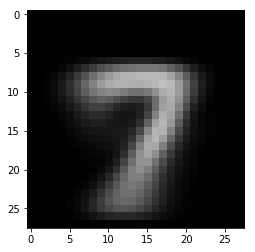

In [14]:
plt.imshow((mean_3.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

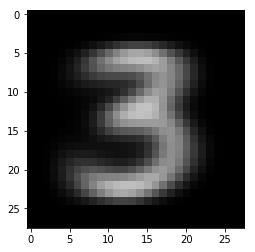

In [15]:
mean_7=gmm_full.means_[1,:]
plt.imshow((mean_7.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

### Evaluating the GMM on the test data

In [16]:
y_predict=gmm_full.predict(te_3_7)

In [18]:
# Evaluating the predictive ability of the Gaussian Mixture Model, approximation of \epsilon
count=0.0
for i in range(len(y_predict)):
    if y_te_3_7_2[i]==y_predict[i]:
        count=count+1
print 1-count/len(y_predict)

0.931305201178


### True and predicted means

In [19]:
# Finding the difference in means to get a sense of the distance
mean_diff=mean_3-mean_7
mean_dist=np.linalg.norm(mean_diff)
print mean_dist

5.04029879668


In [20]:
mean_3_true = np.mean(X_train[tr_3_i],axis=0)
mean_7_true = np.mean(X_train[tr_7_i],axis=0)
mean_diff_true = mean_3_true-mean_7_true
mean_dist_true=np.linalg.norm(mean_diff_true)
print mean_dist_true

5.17601


### Fitting a simple linear classifier to the data

In [21]:
from sklearn.linear_model import Perceptron

In [22]:
percep=Perceptron()
percep.fit(tr_3_7,y_3_7_2)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [23]:
percep.score(te_3_7,y_te_3_7_2)

0.9823356231599607

In [24]:
w=percep.coef_

In [25]:
# Adding a perturbation perpendicular to the boundary for all images from class 7
te_3_7_orig=te_3_7.copy()
for i in range(len(te_3_7)):
    if y_te_3_7_2[i]==1:
        te_3_7[i]=te_3_7[i]-2.0*w/(np.linalg.norm(w))

In [26]:
percep.score(te_3_7,y_te_3_7_2)

0.48773307163886165

In [28]:
predict_adv=gmm_full.predict(te_3_7)
count=0.0
for i in range(len(y_te_3_7_2)):
    if y_te_3_7_2[i]==predict_adv[i]:
        count=count+1
print 1-count/len(y_te_3_7_2)

0.828753680079


### Original and adversarial images

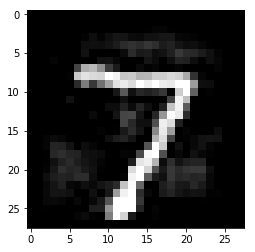

In [51]:
plt.imshow((te_3_7[0].reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

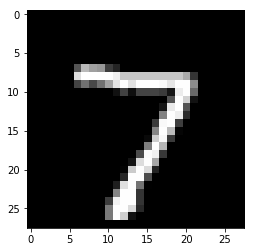

In [53]:
plt.imshow((te_3_7_orig[0].reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

In [54]:
gmm_adv=GaussianMixture(n_components=2,covariance_type='diag')
gmm_adv.fit(te_3_7,y_te_3_7_2)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

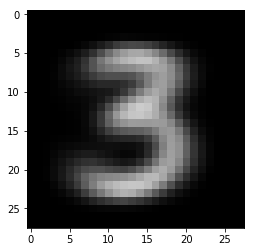

In [55]:
mean_7=gmm_adv.means_[0,:]
plt.imshow((mean_7.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

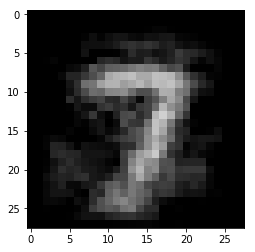

In [56]:
mean_3=gmm_adv.means_[1,:]
plt.imshow((mean_3.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)

### Checking effectiveness of difference of means perturbation

In [57]:
gmm_adv.weights_

array([ 0.49018646,  0.50981354])

In [53]:
cosine_w_means=np.dot(w,-mean_diff)/(np.linalg.norm(w)*np.linalg.norm(mean_diff))

In [54]:
cosine_w_means

array([ 0.38817089])

In [58]:
angle=np.arccos(cosine_w_means)
print np.degrees(angle)

[ 67.1592656]


In [65]:
te_3_7_two=te_3_7_orig.copy()
for i in range(len(te_3_7)):
    if y_te_flip[i]==1:
        te_3_7_two[i]=te_3_7_two[i]+2.0*mean_diff/(np.linalg.norm(mean_diff))

In [66]:
percep.score(te_3_7_two,y_te_flip)

0.88763493621197254

In [69]:
percep.score(te_3_7_orig,y_te_flip)

0.9823356231599607